Here we will show an example of how to run deepblast on simulation data.

In [1]:
import os
import pandas as pd
from deepblast.sim import hmm_alignments
import argparse

We will first simulate multiple sequences from a single PFam family.
The resulting generated alignments will be used to train the model.

In [2]:
fname = '../data/tm_align_output_10k.tab'
cols = [
    'chain1_name', 'chain2_name', 'tmscore1', 'tmscore2', 'rmsd',
    'chain1', 'chain2', 'alignment'
]
align_df = pd.read_table(fname, header=None, sep='\s+')
align_df.columns = cols
n_alignments = align_df.shape[0]

The simulated alignments will be split into training / testing and validation.

In [3]:
parts = n_alignments // 10
train_df = align_df.iloc[:parts * 8]
test_df = align_df.iloc[parts * 8:parts * 9]
valid_df = align_df.iloc[parts * 9:]

# save the files to disk.
train_df.to_csv('data/train.txt', sep='\t', index=None, header=None)
test_df.to_csv('data/test.txt', sep='\t', index=None, header=None)
valid_df.to_csv('data/valid.txt', sep='\t', index=None, header=None)

We will prepare the environment to make sure that the appropriate output directories exist to store the results.

In [4]:
from deepblast.trainer import LightningAligner
from pytorch_lightning import Trainer

output_dir = 'struct_results'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [5]:
os.getcwd()

'/home/juermieboop/Documents/research/garfunkel/ipynb'

We will now create the arguments.  Below is the way to create this in a python environment.
This can also be recreated on a standard command line interface.

In [6]:
args = [
    '--train-pairs', f'{os.getcwd()}/data/train.txt',
    '--test-pairs', f'{os.getcwd()}/data/test.txt',
    '--valid-pairs', f'{os.getcwd()}/data/valid.txt',
    '--output-directory', output_dir,
    '--epochs', '128',
    '--batch-size', '20',  
    '--num-workers', '16',
    '--layers', '1',
    '--heads', '1',
    '--learning-rate', '5e-5',
    '--visualization-fraction', '1',
    '--loss', 'cross_entropy',
    '--scheduler', 'inv_steplr',  
    '--clip-ends', 'True',
    '--gpus', '1'
]

We will then initialize the alignment model with the parameters we specified earlier.

In [7]:
parser = argparse.ArgumentParser(add_help=False)
parser = LightningAligner.add_model_specific_args(parser)
parser.add_argument('--num-workers', type=int)
parser.add_argument('--gpus', type=int)
args = parser.parse_args(args)
model = LightningAligner(args)

In [8]:
args

Namespace(batch_size=20, clip_ends=True, embedding_dim=512, epochs=128, finetune=False, gpus=1, heads=1, layers=1, learning_rate=5e-05, loss='cross_entropy', multitask=False, num_workers=16, output_directory='struct_results', rnn_dim=512, rnn_input_dim=512, scheduler='inv_steplr', test_pairs='/home/juermieboop/Documents/research/garfunkel/ipynb/data/test.txt', train_pairs='/home/juermieboop/Documents/research/garfunkel/ipynb/data/train.txt', valid_pairs='/home/juermieboop/Documents/research/garfunkel/ipynb/data/valid.txt', visualization_fraction=1.0)

We can now train the model.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                   | Params
---------------------------------------------------
0 | aligner | NeedlemanWunschAligner | 13 M  


tensor(0.5726, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.8023, device='cuda:0', grad_fn=<VarBackward0>)
tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>) tensor(88.0248, device='cuda:0', grad_fn=<VarBackward0>)


KeyboardInterrupt: 

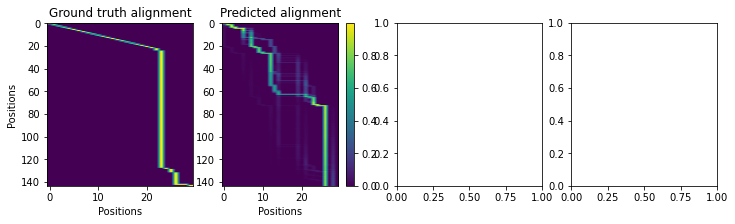

In [9]:
from pytorch_lightning.profiler import AdvancedProfiler
profiler=AdvancedProfiler()
trainer = Trainer(
    max_epochs=args.epochs,
    gpus=args.gpus,
    check_val_every_n_epoch=8,
    #profiler=profiler,
    #fast_dev_run=True,
    # auto_scale_batch_size='power'
)

trainer.fit(model)

The model diagnostics can be directly visualized in Tensorboard. Here, we show the losses, the accuracy and the alignment results.

In [ ]:
!ls lightning_logs

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir lightning_logs

And we did this with just a few million parameters

In [ ]:
model.aligner

# Evaluate model

In [ ]:
!ls lightning_logs/version_3/checkpoints

In [ ]:
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
checkpoint_dir = 'lightning_logs/version_3/checkpoints'
path = f'{checkpoint_dir}/epoch=49.ckpt'
model = LightningAligner.load_from_checkpoint(path)

In [ ]:
from deepblast.dataset.dataset import states2matrix, tmstate_f
import numpy as np
import torch
from torch.nn.utils.rnn import pack_sequence
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
i = 0
test = train_df
x = str.encode(test.iloc[i]['chain1'])
y = str.encode(test.iloc[i]['chain2'])
states = test.iloc[i]['alignment']
x_ = torch.Tensor(model.tokenizer(x)).long().unsqueeze(0)
y_ = torch.Tensor(model.tokenizer(y)).long().unsqueeze(0)
x_ = pack_sequence(x_, enforce_sorted=False).cuda()
y_ = pack_sequence(y_, enforce_sorted=False).cuda()
states = list(map(tmstate_f, states))
A = states2matrix(states)

In [ ]:
model = model.cuda()
aln, theta, gap = model.forward(x_, y_)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
sns.heatmap(A, ax=ax[0])
sns.heatmap(aln.cpu().detach().numpy().squeeze(), ax=ax[1])
sns.heatmap(theta.cpu().detach().numpy().squeeze(), ax=ax[2])

In [ ]:
test.iloc[0]['chain1'], test.iloc[0]['chain2']